In [3]:
#Reference :
#RandomForest
#https://github.com/apache/spark/blob/v2.2.0/mllib/src/main/scala/org/apache/spark/ml/classification/RandomForestClassifier.scala#L120
#One hot encoding
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
#LR from scratch
#https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
#https://www.programcreek.com/python/example/106727/pyspark.ml.feature.StringIndexer

#pyspark.mllib vs pyspark.ml
#https://stackoverflow.com/questions/41074182/cannot-convert-type-class-pyspark-ml-linalg-sparsevector-into-vector

In [3]:
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade google-api-python-client
!pip install --upgrade seaborn
!pip install --upgrade networkx
!pip install --upgrade matplotlib
# !pip install --upgrade pyspark
!pip install --upgrade pyspark_dist_explore


Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (18.1)
Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (0.23.4)
    100% |████████████████████████████████| 61kB 3.8MB/s ta 0:00:011
    100% |████████████████████████████████| 71kB 10.1MB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 12.2MB/s ta 0:00:01
    100% |████████████████████████████████| 1.7MB 17.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.6/site-packages (3.0.2)
Requirement already up-to-date: pyspark_dist_explore in /opt/conda/lib/python3.6/site-packages (0.1.4)


In [44]:
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#from pyspark.mllib.linalg import VectorUDT
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import SparseVector
from pyspark.sql import functions as F, types
from pyspark.sql.functions import (explode, col)
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.functions import trim
from pyspark.sql.functions import udf
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType
from pyspark.sql.types import Row
from pyspark.sql.window import Window
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time



from pyspark.ml.linalg import Vectors
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [6]:
%matplotlib inline


In [5]:
spark

In [7]:
sc = spark.sparkContext

In [8]:
sc.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.driver.maxResultSize', '13312m'),
 ('spark.yarn.historyServer.address', 'w266finalprojectajh5-m:18080'),
 ('spark.executor.memory', '37237m'),
 ('spark.history.fs.logDirectory',
  'hdfs://w266finalprojectajh5-m/user/spark/eventlog'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.driver.port', '46033'),
 ('spark.executor.instances', '2'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://w266finalprojectajh5-m:8088/proxy/application_1544593636585_0001'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.appUIAddress',
  'http://w266finalprojectajh5-m.c.w266-203601.internal:4040'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.executor.cores', '8'),
 ('spark.eventLog.dir', 'hdfs://w266finalprojectajh5-m/user/spark/eventlog'),
 ('spark.driver.me

In [52]:
# sc.stop()

AttributeError: 'SparkContext' object has no attribute 'restart'

In [49]:
# spark.stop()


## Question Formulation

## Algorithm Explanation

In [16]:
toy_rawDF = sqlContext.read.text('Toy_Example_Data.csv').withColumnRenamed("value", "text")


AnalysisException: 'Path does not exist: hdfs://w266finalprojectajh4-m/user/root/Toy_Example_Data.csv;'

In [ ]:
toy_rawDF.show()


In [ ]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
raw_train_df, raw_validation_df, raw_test_df = toy_rawDF.randomSplit(weights, seed)

# Cache and count the DataFrames
n_train = raw_train_df.cache().count()
n_val = raw_validation_df.cache().count()
n_test = raw_test_df.cache().count()
print(n_train, n_val, n_test, str(n_train + n_val + n_test))


In [ ]:
parsed_train_df = parse_raw_df(raw_train_df)
print(parsed_train_df.head())


In [ ]:
from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())


In [ ]:
print(num_categories)


In [ ]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df)
num_ctr_ohe_feats = len(ctr_ohe_dict)
print(num_ctr_ohe_feats)
ctr_ohe_dict


In [ ]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast)
ohe_train_df =  parsed_train_df.select(parsed_train_df.label, ohe_dict_udf(parsed_train_df.features).alias('features'))
#ohe_train_df.show(1)                  

print(ohe_train_df.count())
print(ohe_train_df.show())
print(ohe_train_df.take(1))


In [ ]:
ohe_train_rdd = ohe_train_df \
                     .rdd \
                     .cache()


In [ ]:
meanDropOut = ohe_train_rdd.map(lambda x: x[0]).mean()
varDropOut = ohe_train_rdd.map(lambda x: x[0]).variance()
print(f"Mean: {meanDropOut}")
print(f"Variance: {varDropOut}")


In [ ]:
BASELINE = np.append(meanDropOut, np.zeros(ohe_train_df.count()))


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [ ]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = LogLoss(trainRDD, model) 
        test_loss = LogLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history


In [ ]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log loss')
    if title:
        plt.title(title)
    plt.show()


In [ ]:
def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1])))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: (-x[0] * np.log(sigmoid(W.dot(x[1]))) - (1 - x[0]) * np.log(1 - sigmoid(W.dot(x[1])))) ).mean()
    ################## (END) YOUR CODE ##################
    return loss


In [ ]:
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: ( x[0], np.append([1.0], x[1]))).cache()
    
    ################## YOUR CODE HERE ################# 
    grad = augmentedData.map(lambda x: (sigmoid(W.dot(x[1])) - x[0])*x[1]).mean()
    new_model = W - learningRate * grad
    ################## (END) YOUR CODE ################# 
    
    return new_model


In [ ]:
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {LogLoss(ohe_train_rdd,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(ohe_train_rdd, model)
    loss = LogLoss(ohe_train_rdd, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")


## EDA & Discussion of Challenges

In [9]:
def f_calc_stats(data, column):
    """
    Calculates mean, minimum value, maximum value, standard deviation, variance, skewness of a column in a dataframe.
    Returns a list containing mean, minimum value, maximum value, standard deviation, variance, skewness
    Args:
        data         - dataframe on which we are calculating statistics.
        column       - column for which statistics have to be calculated
    Returns:
        A list containing the mean, minimum value, maximum value, standard deviation, variance, skewness of the column.
    """
    
    return data.agg(F.avg(data[column]), F.min(data[column]), F.max(data[column]),
                    F.stddev_pop(data[column]),F.var_pop(data[column]),F.skewness(data[column])
                   ).collect()

In [10]:
def f_check_null(data, column):
    """
    Calculates count of null or NaN or empty for a column.
    Returns an integer for the count  of null or NaN or empty for a column.
    Args:
        data         - dataframe on which we are calculating the metric.
        column       - column for which the metric has to be calculated.
    Returns:
        An integer for the count where the column is null or NaN or empty.
    """
    return data.filter( (data[column] =="") |F.isnull(data[column])|F.isnan(data[column])
                      ).count()

In [11]:
#Checking cardinality
def f_display_stats_categ(df, inColList):
    """
    Calculates count of unique values and empty strings for a column.
    Displays the output as a HTML table.
    Args:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    for col in inColList:
        cardinal_cnt = df.select([col]).distinct().count()
        dict1[col]={"Count_Unique_Vals":cardinal_cnt}
        dict1[col]['Count_Empty_String'] = str(df.filter(df[col] == "").count())

    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [12]:
def f_display_stats_int(data):
    """
    Calls other functions to get mean, minimum value, maximum value, standard deviation, variance, skewness, number of nulls/NaN/empty values of a column in a dataframe..
    Displays the output as a HTML table.
    Args:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    countTotal = data.count()
    for colname in [item[0] for item in data.dtypes if item[1].startswith('double')]:
        list1=f_calc_stats(data,colname)
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = f_check_null(data,colname)
        dict1[colname]={}
        dict1[colname]['mean'] = str(round(mean_val,2))
        dict1[colname]['min'] = str(min_val)
        dict1[colname]['max'] = str(max_val)
        dict1[colname]['stddev'] = str(round(stddev,2))
        dict1[colname]['var'] = str(round(var,2))
        dict1[colname]['skewness'] = str(round(skewness,2))
        dict1[colname]['nulls_nans'] = str(count_nulls)
        dict1[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
        dict1[colname]['count_empty_string'] = str(data.filter(data[colname] == "").count())
        dict1[colname]['count_unique_values'] = str(data.select([colname]).distinct().count())
        dict1[colname]['count'] = 'N/A'
    dict1['TOTAL']={}
    dict1['TOTAL']['count'] = str(data.count())
   #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [13]:
def f_display_corr(df, int_col_list):
    sampleDF=df.sample(seed=1, fraction=0.5, withReplacement=False)
    dict1={}
    for col in int_col_list:
        corr = trainWithColsDF.stat.corr('label',col)
        cov = trainWithColsDF.stat.cov('label',col)
        dict1[col]={}
        dict1[col]["Corr"]=corr
        dict1[col]["Cov"]=cov
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [14]:
#Create dataframe from RDD
def f_covert_to_df(rdd, col_list):
    return rdd.map(lambda x: x.split('\t')).toDF(col_list)

In [15]:
#Convert integer columns to IntegerType from String
def f_cast_str_to_int(df, integer_col_list):
    for col in integer_col_list:
        df = df.withColumn(col, df[col].cast(types.IntegerType()))
    return df

In [16]:
#Removing rows where at least one column has empty string
def f_remove_empty_string(df, categ_col_list):
    for categ_col in categ_col_list:
        df = df.filter(df[categ_col] != "")
        #df = df.filter(col(categ_col) != "")
    return df

In [17]:
labelColList=["clicked_0_1"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7", "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12", "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18", "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [18]:
def parse_point(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split('\t')[1:]
    #values = filter(None, values)
    indices = range(len(values))
    return zip(indices,values)




In [19]:
parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.


    Args:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
  
    """
    return (raw_df.select(split(raw_df.text,'\t').getItem(0).cast("double").alias('label'),
                         parse_point_udf(raw_df.text).alias('features'))
                        .cache())


In [20]:
# rawDF = sqlContext.read.text('gs://bucket-w261-final/data/train.txt').withColumnRenamed("value", "text")

rawDF = sqlContext.read.text('gs://w261_final_project_ajh_bucket/data/train.txt').withColumnRenamed("value", "text")


In [21]:
weights = [.8, .1, .1]
seed = 1

# Use randomSplit with weights and seed
rawTrainDF, rawValidationDF, rawTestDF = rawDF.randomSplit(weights, seed)


In [22]:
#25% sampling due to memory errors
rawTrainNewDF = rawTrainDF.sample(withReplacement=False, fraction=0.25, seed=1)

In [23]:
rawTrainNewDF.cache()
rawValidationDF.cache()
rawTestDF.cache()

DataFrame[text: string]

In [24]:
rawTrainNewDF.count()

9167896

In [25]:
rawTrainNewDF.columns

['text']

In [26]:
trainWithColsDF=rawTrainNewDF.withColumn('tmp', split('text', '\t')).select( col("tmp").getItem(0).cast("double").alias("label")
                                                                            ,col("tmp").getItem(1).cast("double").alias("int_1")
                                                                            ,col("tmp").getItem(2).cast("double").alias("int_2")
                                                                            ,col("tmp").getItem(3).cast("double").alias("int_3")
                                                                            ,col("tmp").getItem(4).cast("double").alias("int_4")
                                                                            ,col("tmp").getItem(5).cast("double").alias("int_5")
                                                                            ,col("tmp").getItem(6).cast("double").alias("int_6")
                                                                            ,col("tmp").getItem(7).cast("double").alias("int_7")
                                                                            ,col("tmp").getItem(8).cast("double").alias("int_8")
                                                                            ,col("tmp").getItem(9).cast("double").alias("int_9")
                                                                            ,col("tmp").getItem(10).cast("double").alias("int_10")
                                                                            ,col("tmp").getItem(11).cast("double").alias("int_11")
                                                                            ,col("tmp").getItem(12).cast("double").alias("int_12")
                                                                            ,col("tmp").getItem(13).cast("double").alias("int_13")
                                                                            ,col("tmp").getItem(14).alias("categ_1")
                                                                            ,col("tmp").getItem(15).alias("categ_2")
                                                                            ,col("tmp").getItem(16).alias("categ_3")
                                                                            ,col("tmp").getItem(17).alias("categ_4")
                                                                            ,col("tmp").getItem(18).alias("categ_5")
                                                                            ,col("tmp").getItem(19).alias("categ_6")
                                                                            ,col("tmp").getItem(20).alias("categ_7")
                                                                            ,col("tmp").getItem(21).alias("categ_8")
                                                                            ,col("tmp").getItem(22).alias("categ_9")
                                                                            ,col("tmp").getItem(23).alias("categ_10")
                                                                            ,col("tmp").getItem(24).alias("categ_11")
                                                                            ,col("tmp").getItem(25).alias("categ_12")
                                                                            ,col("tmp").getItem(26).alias("categ_13")
                                                                            ,col("tmp").getItem(27).alias("categ_14")
                                                                            ,col("tmp").getItem(28).alias("categ_15")
                                                                            ,col("tmp").getItem(29).alias("categ_16")
                                                                            ,col("tmp").getItem(30).alias("categ_17")
                                                                            ,col("tmp").getItem(31).alias("categ_18")
                                                                            ,col("tmp").getItem(32).alias("categ_19")
                                                                            ,col("tmp").getItem(33).alias("categ_20")
                                                                            ,col("tmp").getItem(34).alias("categ_21")
                                                                            ,col("tmp").getItem(35).alias("categ_22")
                                                                            ,col("tmp").getItem(36).alias("categ_23")
                                                                            ,col("tmp").getItem(37).alias("categ_24")
                                                                            ,col("tmp").getItem(38).alias("categ_25")
                                                                            ,col("tmp").getItem(39).alias("categ_26")
                                                            ).cache()

In [27]:
rawTrainNewDF.first()

Row(text='0\t\t-1\t\t\t\t\t\t\t\t\t\t\t\t05db9164\t38a947a1\t\t\t25c83c98\t\t1d7560d9\t64523cfa\t7cc72ec2\t3b08e48b\t8951ed6a\t\t27dc8af3\tb28479f6\t4df46b2c\t\t2005abd1\t40685634\t\t\t\t\t32c7478e\t\t\t')

In [28]:
trainWithColsDF.first()

Row(label=0.0, int_1=None, int_2=-1.0, int_3=None, int_4=None, int_5=None, int_6=None, int_7=None, int_8=None, int_9=None, int_10=None, int_11=None, int_12=None, int_13=None, categ_1='05db9164', categ_2='38a947a1', categ_3='', categ_4='', categ_5='25c83c98', categ_6='', categ_7='1d7560d9', categ_8='64523cfa', categ_9='7cc72ec2', categ_10='3b08e48b', categ_11='8951ed6a', categ_12='', categ_13='27dc8af3', categ_14='b28479f6', categ_15='4df46b2c', categ_16='', categ_17='2005abd1', categ_18='40685634', categ_19='', categ_20='', categ_21='', categ_22='', categ_23='32c7478e', categ_24='', categ_25='', categ_26='')

In [29]:
labelColList=["label"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7", "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12", "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18", "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [30]:
f_display_stats_int(trainWithColsDF)
f_display_stats_categ(trainWithColsDF, categColList)
print("Correlation and Covariance w.r.t target field")
f_display_corr(trainWithColsDF, intColList)


,count,count_empty_string,count_unique_values,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
label,N/A,0,2,1.0,0.26,0.0,0,0.0,1.12,0.44,0.19
int_1,N/A,0,456,2047.0,3.5,0.0,4159327,45.37,18.49,9.4,88.44
int_2,N/A,0,6850,35521.0,105.91,-3.0,0,0.0,7.22,390.39,152401.51
int_3,N/A,0,5781,65535.0,26.72,0.0,1966409,21.45,83.89,392.27,153878.42
int_4,N/A,0,292,877.0,7.32,0.0,1987342,21.68,3.94,8.77,76.98
int_5,N/A,0,256027,23159456.0,18563.68,0.0,236154,2.58,13.23,69907.29,4887029138.95
int_6,N/A,0,7358,430898.0,115.93,0.0,2050660,22.37,284.12,411.87,169638.19
int_7,N/A,0,2727,34536.0,16.36,0.0,397046,4.33,48.8,67.18,4513.3
int_8,N/A,0,747,5664.0,12.52,0.0,4476,0.05,66.97,16.63,276.56
int_9,N/A,0,5142,29019.0,106.11,0.0,397046,4.33,8.55,220.01,48405.18


,Count_Empty_String,Count_Unique_Vals
categ_1,0,1458
categ_2,0,562
categ_3,311243,2539621
categ_4,311243,701163
categ_5,0,305
categ_6,1110211,23
categ_7,0,12238
categ_8,0,633
categ_9,0,3
categ_10,0,64089


Correlation and Covariance w.r.t target field


,Corr,Cov
int_1,0.104506,0.326917
int_2,0.044621,7.603534
int_3,0.009372,1.422942
int_4,-0.055757,-0.202735
int_5,-0.076178,-2296.478111
int_6,-0.051921,-8.296947
int_7,0.083761,2.405540
int_8,-0.027570,-0.200104
int_9,0.024018,2.267424
int_10,0.191403,0.049470


# EDA Stats on Full Dataset

In [31]:
rawDF.cache()

DataFrame[text: string]

In [142]:
rawDF_count = rawDF.count()
print(rawDF_count)

45840617


In [34]:
rawDF.columns

['text']

In [35]:
fullWithColsDF=rawDF.withColumn('tmp', split('text', '\t')).select( col("tmp").getItem(0).cast("double").alias("label")
                                                                            ,col("tmp").getItem(1).cast("double").alias("int_1")
                                                                            ,col("tmp").getItem(2).cast("double").alias("int_2")
                                                                            ,col("tmp").getItem(3).cast("double").alias("int_3")
                                                                            ,col("tmp").getItem(4).cast("double").alias("int_4")
                                                                            ,col("tmp").getItem(5).cast("double").alias("int_5")
                                                                            ,col("tmp").getItem(6).cast("double").alias("int_6")
                                                                            ,col("tmp").getItem(7).cast("double").alias("int_7")
                                                                            ,col("tmp").getItem(8).cast("double").alias("int_8")
                                                                            ,col("tmp").getItem(9).cast("double").alias("int_9")
                                                                            ,col("tmp").getItem(10).cast("double").alias("int_10")
                                                                            ,col("tmp").getItem(11).cast("double").alias("int_11")
                                                                            ,col("tmp").getItem(12).cast("double").alias("int_12")
                                                                            ,col("tmp").getItem(13).cast("double").alias("int_13")
                                                                            ,col("tmp").getItem(14).alias("categ_1")
                                                                            ,col("tmp").getItem(15).alias("categ_2")
                                                                            ,col("tmp").getItem(16).alias("categ_3")
                                                                            ,col("tmp").getItem(17).alias("categ_4")
                                                                            ,col("tmp").getItem(18).alias("categ_5")
                                                                            ,col("tmp").getItem(19).alias("categ_6")
                                                                            ,col("tmp").getItem(20).alias("categ_7")
                                                                            ,col("tmp").getItem(21).alias("categ_8")
                                                                            ,col("tmp").getItem(22).alias("categ_9")
                                                                            ,col("tmp").getItem(23).alias("categ_10")
                                                                            ,col("tmp").getItem(24).alias("categ_11")
                                                                            ,col("tmp").getItem(25).alias("categ_12")
                                                                            ,col("tmp").getItem(26).alias("categ_13")
                                                                            ,col("tmp").getItem(27).alias("categ_14")
                                                                            ,col("tmp").getItem(28).alias("categ_15")
                                                                            ,col("tmp").getItem(29).alias("categ_16")
                                                                            ,col("tmp").getItem(30).alias("categ_17")
                                                                            ,col("tmp").getItem(31).alias("categ_18")
                                                                            ,col("tmp").getItem(32).alias("categ_19")
                                                                            ,col("tmp").getItem(33).alias("categ_20")
                                                                            ,col("tmp").getItem(34).alias("categ_21")
                                                                            ,col("tmp").getItem(35).alias("categ_22")
                                                                            ,col("tmp").getItem(36).alias("categ_23")
                                                                            ,col("tmp").getItem(37).alias("categ_24")
                                                                            ,col("tmp").getItem(38).alias("categ_25")
                                                                            ,col("tmp").getItem(39).alias("categ_26")
                                                            ).cache()

In [36]:
rawDF.first()

Row(text='0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16')

In [37]:
fullWithColsDF.first()

Row(label=0.0, int_1=1.0, int_2=1.0, int_3=5.0, int_4=0.0, int_5=1382.0, int_6=4.0, int_7=15.0, int_8=2.0, int_9=181.0, int_10=1.0, int_11=2.0, int_12=None, int_13=2.0, categ_1='68fd1e64', categ_2='80e26c9b', categ_3='fb936136', categ_4='7b4723c4', categ_5='25c83c98', categ_6='7e0ccccf', categ_7='de7995b8', categ_8='1f89b562', categ_9='a73ee510', categ_10='a8cd5504', categ_11='b2cb9c98', categ_12='37c9c164', categ_13='2824a5f6', categ_14='1adce6ef', categ_15='8ba8b39a', categ_16='891b62e7', categ_17='e5ba7672', categ_18='f54016b9', categ_19='21ddcdc9', categ_20='b1252a9d', categ_21='07b5194c', categ_22='', categ_23='3a171ecb', categ_24='c5c50484', categ_25='e8b83407', categ_26='9727dd16')

In [38]:
labelColList=["label"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7", "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12", "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18", "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [39]:
f_display_stats_int(fullWithColsDF)
f_display_stats_categ(fullWithColsDF, categColList)
print("Correlation and Covariance w.r.t target field")
f_display_corr(fullWithColsDF, intColList)


,count,count_empty_string,count_unique_values,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
label,N/A,0,2,1.0,0.26,0.0,0,0.0,1.12,0.44,0.19
int_1,N/A,0,649,5775.0,3.5,0.0,20793556,45.36,27.88,9.43,88.91
int_2,N/A,0,9364,257675.0,105.85,-3.0,0,0.0,13.2,391.46,153239.22
int_3,N/A,0,14746,65535.0,26.91,0.0,9839447,21.46,81.49,397.97,158382.17
int_4,N/A,0,490,969.0,7.32,0.0,9937369,21.68,4.09,8.79,77.32
int_5,N/A,0,476707,23159456.0,18538.99,0.0,1183117,2.58,10.1,69394.6,4815610657.56
int_6,N/A,0,11618,431037.0,116.06,0.0,10252328,22.37,184.98,382.57,146357.08
int_7,N/A,0,4142,56311.0,16.33,0.0,1982866,4.33,46.39,66.05,4362.57
int_8,N/A,0,1373,6047.0,12.52,0.0,22773,0.05,66.16,16.69,278.52
int_9,N/A,0,7275,29019.0,106.11,0.0,1982866,4.33,8.52,220.28,48524.64


,Count_Empty_String,Count_Unique_Vals
categ_1,0,1460
categ_2,0,583
categ_3,1559473,10131227
categ_4,1559473,2202608
categ_5,0,305
categ_6,5540625,24
categ_7,0,12517
categ_8,0,633
categ_9,0,3
categ_10,0,93145


Correlation and Covariance w.r.t target field


,Corr,Cov
int_1,0.104506,0.326917
int_2,0.044621,7.603534
int_3,0.009372,1.422942
int_4,-0.055757,-0.202735
int_5,-0.076178,-2296.478111
int_6,-0.051921,-8.296947
int_7,0.083761,2.405540
int_8,-0.027570,-0.200104
int_9,0.024018,2.267424
int_10,0.191403,0.049470


In [56]:
# Select only numerical columns
fullWithColsDF_int = fullWithColsDF.select(intColList)

In [61]:
fullWithColsDF_int.head()

Row(int_1=1.0, int_2=1.0, int_3=5.0, int_4=0.0, int_5=1382.0, int_6=4.0, int_7=15.0, int_8=2.0, int_9=181.0, int_10=1.0, int_11=2.0, int_12=None, int_13=2.0)

In [109]:
correlation_df = fullWithColsDF_int.na.fill(0)

# Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(correlation_df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [184]:
intColList_ex = intColList=["int_01", "int_02", "int_03", "int_04", "int_05", "int_06", "int_07", "int_08", "int_09", "int_10", "int_11", "int_12", "int_13"]


# matrix.show()
correlation_matrix = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values)
correlation_matrix = correlation_matrix.values.reshape(13, 13)
correlation_matrix = pd.DataFrame(correlation_matrix, columns = intColList_ex, index = intColList_ex)
correlation_matrix

,int_01,int_02,int_03,int_04,int_05,int_06,int_07,int_08,int_09,int_10,int_11,int_12,int_13
int_01,1.000000,0.034108,0.038390,0.081069,-0.068993,-0.058315,0.477780,0.097048,0.068316,0.465176,0.304534,0.092164,0.005279
int_02,0.034108,1.000000,-0.008308,-0.081530,-0.006260,-0.013320,0.025422,-0.028035,-0.004732,0.035712,0.032760,-0.001294,-0.034543
int_03,0.038390,-0.008308,1.000000,0.042022,-0.003412,0.005079,0.000373,0.045087,-0.000465,-0.003791,-0.005823,-0.001431,0.030109
int_04,0.081069,-0.081530,0.042022,1.000000,-0.094468,0.015560,0.038521,0.504384,0.194364,0.157900,0.063999,0.021092,0.612960
int_05,-0.068993,-0.006260,-0.003412,-0.094468,1.000000,0.002158,-0.056270,-0.109468,-0.068310,-0.148043,-0.115582,-0.020923,-0.054280
int_06,-0.058315,-0.013320,0.005079,0.015560,0.002158,1.000000,-0.027060,0.022175,0.186576,-0.124605,-0.039072,-0.012915,0.045574
int_07,0.477780,0.025422,0.000373,0.038521,-0.056270,-0.027060,1.000000,0.077122,0.233840,0.251448,0.685523,0.093341,0.003478
int_08,0.097048,-0.028035,0.045087,0.504384,-0.109468,0.022175,0.077122,1.000000,0.206472,0.156661,0.139375,0.028334,0.631302
int_09,0.068316,-0.004732,-0.000465,0.194364,-0.068310,0.186576,0.233840,0.206472,1.000000,0.075001,0.403943,0.045726,0.192788
int_10,0.465176,0.035712,-0.003791,0.157900,-0.148043,-0.124605,0.251448,0.156661,0.075001,1.000000,0.386369,0.084908,0.023659


### Sample Data for Graphs

In [185]:
# sample_df = fullWithColsDF.sample(False, fraction=1000/rawDF_count, seed = 1)
sample_df = fullWithColsDF.sample(False, fraction=0.0001, seed = 1)
sample_df.cache()

DataFrame[label: double, int_1: double, int_2: double, int_3: double, int_4: double, int_5: double, int_6: double, int_7: double, int_8: double, int_9: double, int_10: double, int_11: double, int_12: double, int_13: double, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [186]:
# Convert to Pandas DataFrame
pd_sample_df = sample_df.toPandas()

In [187]:
# sample_df.printSchema()
sample_df.count()

4558

In [188]:
print(type(pd_sample_df))

<class 'pandas.core.frame.DataFrame'>


In [189]:
pd_sample_df.head()

,label,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,...,categ_17,categ_18,categ_19,categ_20,categ_21,categ_22,categ_23,categ_24,categ_25,categ_26
0,0.0,0.0,1.0,NaN,0.0,3021.0,9.0,6.0,2.0,16.0,...,e5ba7672,005c6740,21ddcdc9,b1252a9d,8717ea07,,423fab69,1793a828,e8b83407,b9809574
1,0.0,2.0,-1.0,150.0,2.0,89.0,24.0,5.0,38.0,42.0,...,e5ba7672,891589e7,4764bf77,5840adea,0bf4a9b7,,bcdee96c,3fdb382b,ea9a246c,49d68486
2,0.0,0.0,2.0,5.0,4.0,17313.0,526.0,2.0,6.0,80.0,...,e5ba7672,963139a7,21ddcdc9,b1252a9d,87cd3c7c,ad3062eb,3a171ecb,1793a828,e8b83407,31129d1d
3,0.0,5.0,11.0,45.0,2.0,18.0,4.0,5.0,2.0,2.0,...,07c540c4,ffd53157,21ddcdc9,5840adea,5f957280,,bcdee96c,1793a828,e8b83407,414c6af0
4,0.0,0.0,100.0,3.0,5.0,5290.0,172.0,4.0,24.0,169.0,...,e5ba7672,52e44668,,,0014c32a,c9d4222a,423fab69,3b183c5c,,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f047418d0>,
      dtype=object)

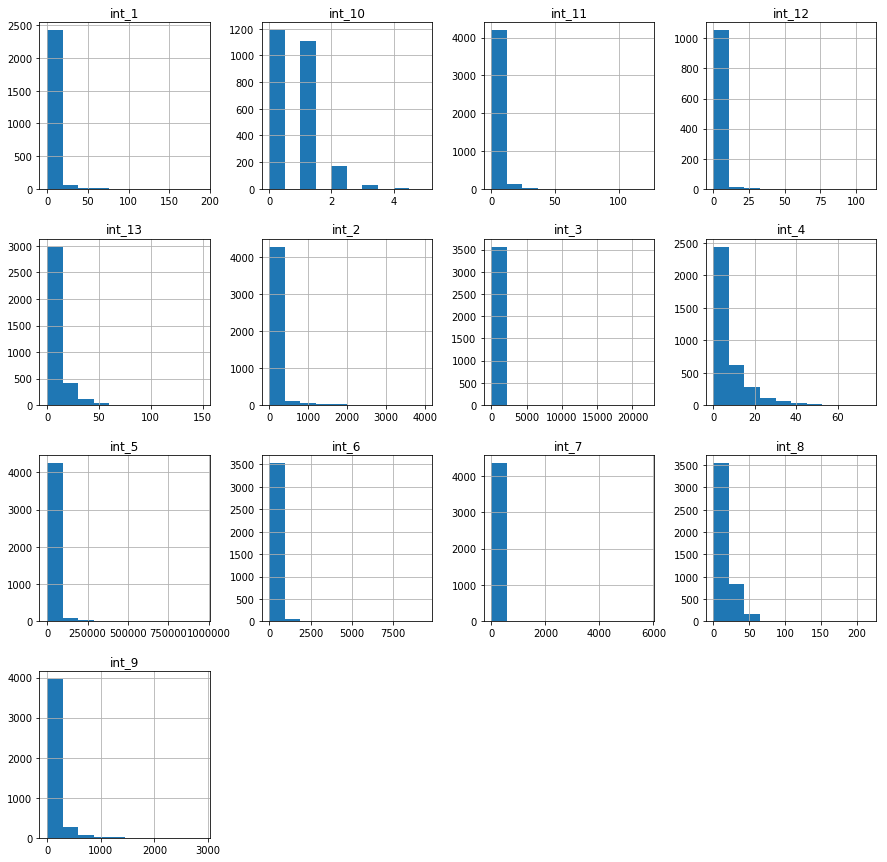

In [183]:
pd_sample_df[intColList].hist(figsize = (15,15))

In [164]:
# import statsmodels.formula.api as smf

# # For plotting/checking assumptions
# import seaborn as sns

ModuleNotFoundError: No module named 'statsmodels'

## Algorithm Implementation

In [30]:
#http://lncohn.com/spark/ctr.html

In [15]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)


In [16]:

def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())



In [17]:
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict



In [186]:
parsed_train_df = parse_raw_df(rawTrainNewDF)
parsed_validation_df = parse_raw_df(rawValidationDF)
parsed_test_df = parse_raw_df(rawTestDF)


In [188]:
parsed_train_df.cache()
parsed_validation_df.cache()
parsed_test_df.cache()


DataFrame[label: double, features: array<struct<_1:bigint,_2:string>>]

In [44]:
parsed_train_df.count()

9168574

In [27]:
parsed_train_df.head()

Row(label=0.0, features=[Row(_1=0, _2='1382'), Row(_1=1, _2='5'), Row(_1=2, _2='4'), Row(_1=3, _2='1'), Row(_1=4, _2='181'), Row(_1=5, _2='fb936136'), Row(_1=6, _2='37c9c164'), Row(_1=7, _2='07b5194c'), Row(_1=8, _2='891b62e7'), Row(_1=9, _2='7b4723c4'), Row(_1=10, _2='c5c50484'), Row(_1=11, _2='9727dd16')])

In [219]:
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())


In [220]:
num_categories

[Row(featureNumber=0, sum(featureNumber)=0),
 Row(featureNumber=1, sum(featureNumber)=6850),
 Row(featureNumber=2, sum(featureNumber)=11562),
 Row(featureNumber=3, sum(featureNumber)=876),
 Row(featureNumber=4, sum(featureNumber)=1024108),
 Row(featureNumber=5, sum(featureNumber)=36790),
 Row(featureNumber=6, sum(featureNumber)=16362),
 Row(featureNumber=7, sum(featureNumber)=5229),
 Row(featureNumber=8, sum(featureNumber)=41136),
 Row(featureNumber=9, sum(featureNumber)=99),
 Row(featureNumber=10, sum(featureNumber)=1470),
 Row(featureNumber=11, sum(featureNumber)=2915),
 Row(featureNumber=12, sum(featureNumber)=8088),
 Row(featureNumber=13, sum(featureNumber)=18954),
 Row(featureNumber=14, sum(featureNumber)=7868),
 Row(featureNumber=15, sum(featureNumber)=38094315),
 Row(featureNumber=16, sum(featureNumber)=11218608),
 Row(featureNumber=17, sum(featureNumber)=5185),
 Row(featureNumber=18, sum(featureNumber)=414),
 Row(featureNumber=19, sum(featureNumber)=232522),
 Row(featureNumber=

### Create an OHE dictionary from the dataset


In [221]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df)
num_ctr_ohe_feats = len(ctr_ohe_dict)
print(num_ctr_ohe_feats)
print(ctr_ohe_dict[(0, '')])


9444472
8499753


### Apply OHE to the dataset


In [222]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast)


In [223]:
ohe_train_df =  parsed_train_df.select(parsed_train_df.label, ohe_dict_udf(parsed_train_df.features).alias('features'))
ohe_train_df.cache()


DataFrame[label: double, features: vector]

### (3f) Handling unseen features


In [224]:
def one_hot_encoding_v2(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len([feat for feat in raw_feats if feat in ohe_dict_broadcast.value] ))
#     values = np.ones(len([raw_feats]))
    return SparseVector(num_ohe_feats,indices,values)

def ohe_udf_generator_v2(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding_v2(x, ohe_dict_broadcast, length), VectorUDT())


In [252]:
ohe_dict_missing_udf = ohe_udf_generator_v2(ohe_dict_broadcast)

ohe_test_df = parsed_test_df.select(parsed_test_df.label,  ohe_dict_missing_udf(parsed_test_df.features).alias('features')).cache()



In [253]:
print(ohe_test_df.count())
print(ohe_test_df.show(1, truncate=False))


4585725
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
+-----+-------------

In [228]:
ohe_train_df.first()

Row(label=0.0, features=SparseVector(9444472, {282595: 1.0, 424288: 1.0, 659969: 1.0, 706928: 1.0, 989772: 1.0, 1320318: 1.0, 1557022: 1.0, 1557023: 1.0, 1557024: 1.0, 2123207: 1.0, 2264580: 1.0, 2406696: 1.0, 2736370: 1.0, 3113587: 1.0, 3255788: 1.0, 4010909: 1.0, 4153235: 1.0, 4200705: 1.0, 4200706: 1.0, 4297751: 1.0, 4814588: 1.0, 4909212: 1.0, 5146054: 1.0, 5524541: 1.0, 5808565: 1.0, 5903591: 1.0, 6233661: 1.0, 6611261: 1.0, 6705776: 1.0, 6894897: 1.0, 7602305: 1.0, 8074256: 1.0, 8358485: 1.0, 8405758: 1.0, 8452489: 1.0, 8499753: 1.0, 9161299: 1.0, 9350284: 1.0, 9350285: 1.0}))

In [254]:
ohe_test_df.first()

Row(label=0.0, features=SparseVector(9444472, {282595: 1.0, 424288: 1.0, 659969: 1.0, 706928: 1.0, 1320318: 1.0, 1557022: 1.0, 1557024: 1.0, 1604081: 1.0, 2264580: 1.0, 2406696: 1.0, 2500892: 1.0, 2736370: 1.0, 3113587: 1.0, 3255788: 1.0, 4010909: 1.0, 4058045: 1.0, 4153235: 1.0, 4200705: 1.0, 4578630: 1.0, 4814588: 1.0, 4909212: 1.0, 5146054: 1.0, 5524541: 1.0, 5808565: 1.0, 5855851: 1.0, 6091432: 1.0, 6233661: 1.0, 6611261: 1.0, 6705776: 1.0, 7602305: 1.0, 7884943: 1.0, 8074256: 1.0, 8358485: 1.0, 8405758: 1.0, 8452489: 1.0, 8499753: 1.0, 9161299: 1.0, 9350284: 1.0, 9350285: 1.0}))

## Part 4: CTR prediction and logloss evaluation


### (4a) Logistic regression


In [229]:
standardization = False
elastic_net_param = 0.0
reg_param = .01
max_iter = 5

lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param, fitIntercept=True,  standardization=standardization)

lr_model_basic = lr.fit(ohe_train_df)

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]
print(sorted_coefficients)


intercept: -1.0661652510744617
length of coefficients: 9444472
[-0.0015861844761605752, -0.0015861170660600307, -0.0015861170660600307, -0.0015861170660600307, -0.0015804214023579803]


In [243]:
save_location="gs://bucket-w261-final/data/lr_model_basic.txt"
lr_model_basic.write().overwrite().save(save_location)


### (4b) Log loss


In [97]:
from pyspark.sql.functions import when, log, col
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
        
        if y == 1:
          return -log(epsilon + p) if p == 0 else -log(p)
        elif y == 0:
          return -log(1 - p + epsilon) if p == 1 else -log(1 - p)
          
         
    """
    
    return (df.select(df['p'],df['label'],
                when(df['label']==1.0,
                     (when(df['p']!=0,-log(df['p'])))
                     .otherwise(-log(epsilon + df['p'])))
               .when(df['label']==0.0,
                     (when(df['p']!=1.0,-log(1.0-df['p'])))
                     .otherwise(-log(1.0 - df['p'] + epsilon)))
               .alias("log_loss")))



## (4c) Baseline log loss


In [245]:
from pyspark.sql.functions import lit
class_one_frac_train = ohe_train_df.select(F.sum('label')).collect()[0][0] / ohe_train_df.count()

ohe_train_df = (ohe_train_df.withColumn("p", lit(class_one_frac_train)))
print('Training class one fraction = {0:.3f}'.format(class_one_frac_train))

log_loss_tr_base = (add_log_loss(ohe_train_df).select(F.sum('log_loss')).collect()[0][0] / ohe_train_df.count())
print('Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base))


Training class one fraction = 0.256
Baseline Train Logloss = 0.569



### (4d) Predicted probability


In [111]:
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model"""
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            features: the features

        Returns:
            float: A probability between 0 and 1.
        """
        # Compute the raw value
        raw_prediction = features.dot(coefficients_broadcast.value)+intercept
        # Bound the raw value between 20 and -20
        raw_prediction = min(raw_prediction, 20)
        raw_prediction = max(raw_prediction, -20)
        return 1.0 / (1.0 + exp(-raw_prediction))

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))



In [246]:
add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()
training_predictions.show(5, truncate=False)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |p        

In [247]:
training_predictions.show(5)


+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(9444472,[282595,...| 0.2538831479776069|
|  0.0|(9444472,[282595,...| 0.2542097290135062|
|  0.0|(9444472,[282595,...|0.25418420627624416|
|  0.0|(9444472,[235571,...|0.25392471262687916|
|  0.0|(9444472,[282595,...|0.25491741985082433|
+-----+--------------------+-------------------+
only showing top 5 rows



### (4e) Evaluate the model


In [116]:
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.

    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.

    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.

    Returns:
        float: Log loss for the data.
    """
    with_probability_df = add_probability(df, model)
    with_log_loss_df = add_log_loss(with_probability_df)
    log_loss = (with_log_loss_df.select(F.sum('log_loss')).collect()[0][0] / with_log_loss_df.count())
    return log_loss


In [248]:
log_loss_train_model_basic = evaluate_results(ohe_train_df, lr_model_basic)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))


OHE Features Train Logloss:
	Baseline = 0.569
	LogReg = 0.567


### (4f) Test dataset log loss


In [256]:
log_loss_val = evaluate_results(ohe_test_df, lr_model_basic)


In [257]:
log_loss_val

0.5678805271280248

In [260]:
temp_ohe_test_df = ohe_test_df

In [273]:
test_predictions = add_probability_model_basic(ohe_test_df).cache()
test_predictions.show(5)


+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(9444472,[282595,...|0.25444869744569376|
|  0.0|(9444472,[235572,...| 0.2528937973315496|
|  0.0|(9444472,[47175,1...|0.25448684505540875|
|  0.0|(9444472,[94556,4...|0.25360390349183876|
|  0.0|(9444472,[424288,...| 0.2546179123892238|
+-----+--------------------+-------------------+
only showing top 5 rows



In [276]:
test_predictions.withColumn("Probability",F.round(col("p"),2) ).groupBy("Probability").agg(F.count(lit(1)).alias("count")).show()
                             

+-----------+-------+
|Probability|  count|
+-----------+-------+
|       0.26|3378245|
|       0.25|1207290|
|       0.27|    190|
+-----------+-------+



In [ ]:
#https://machinelearningmastery.com/k-fold-cross-validation/
#one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.

In [282]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Evaluate model
evaluator = BinaryClassificationEvaluator()


In [ ]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(ohe_train_df)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing


In [ ]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
# evaluator.evaluate(predictions)
